# **1.0 - Preparo do ambiente**

1.   Configuracoes iniciais para inicio do projeto
2.   Carregar o ds em memoria e visualizar as estatisticas
3.   Personalizar as caracteristicas e cores das figuras

## 1.1 - Importando as bibliotecas

In [1]:
# Manipulacao do dataframe
import numpy as np
import pandas as pd

# Plotagem dos graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pre processamento para ML
from sklearn import preprocessing

# Algoritmos de ML
from sklearn.ensemble import RandomForestRegressor

# Tuning do algoritmo
from sklearn.model_selection import GridSearchCV

# Eliminar warnings
import warnings
warnings.filterwarnings("ignore")

## 1.2 - Carregando o dataset

In [2]:
# Upload do conjunto de dados
endereco = '/content/drive/MyDrive/Notebooks/precos_aptos_sao_paulo/'
data = pd.read_csv(endereco + 'precos_aptos_sao_paulo.csv')

# Primeira descricao do df
data.describe()

,metragem,quartos,banheiros,suites,vagas,PRECO_MILHARES
count,15703.000000,15703.000000,15703.000000,15703.000000,15703.000000,15703.000000
mean,128.062345,2.860664,2.467045,0.763357,1.844870,995.773735
std,93.374991,0.783342,1.266961,1.069804,1.014796,858.878453
min,23.000000,1.000000,1.000000,0.000000,1.000000,100.000000
25%,65.000000,2.000000,2.000000,0.000000,1.000000,430.000000
50%,96.000000,3.000000,2.000000,0.000000,2.000000,745.000000
75%,160.000000,3.000000,3.000000,1.000000,2.000000,1272.000000
max,864.000000,8.000000,10.000000,8.000000,10.000000,11000.000000


## 1.3 - Personalizando as figuras

In [3]:
# Setando o estilo do seaborn
sns.set_style('darkgrid')

# Cor principal para os graficso
cor = '#000000'

# **2.0 - Tratamento dos dados**

1.   Manipulacao e criacao de novas features
2.   Abordagem de valores faltantes e outliers
3.   A formula classica de outliers nao foi eficiente
4.   Entao me baseei em pesquisa e analise do ds
5.   Eliminei os bairros com poucas amostras

## 2.1 - Criacao de novas colunas

In [4]:
# Coluna comodos_totais - Soma de quartos, banheiros e suites
data['comodos_totais'] =  data['quartos'] \
                        + data['banheiros'] \
                        + data['suites']

# Coluna preco_m2_milhares - Preco de venda pela metragem
data['preco_m2_milhares'] = round(data['PRECO_MILHARES']
                                / data['metragem'], 3)

## 2.2 - Definindo os outliers

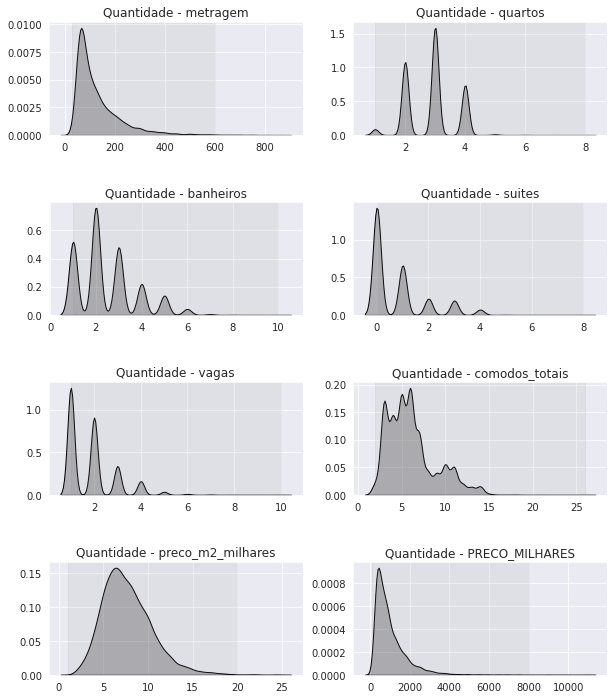

In [5]:
def plot_kde(df, col_x):
    # Plot de grafico kde simples
    sns.kdeplot(col_x,
                data = df,
                shade = True,
                color = cor)
    
    plt.title('Quantidade - {}'.format(col_x))
    
    # Eixo x
    plt.xlabel('')

    #Eixo y
    plt.ylabel('')

def plor_axvspan_nout(min_lim, max_lim):
    # Plot de um destaque em uma area do grafico
    plt.axvspan(min_lim, max_lim,
                alpha= 0.1,
                color= 'grey')

# Criando a figura e plotando os graficos
fig, ax = plt.subplots(figsize = (10, 12))

plt.subplot(4, 2, 1)
plot_kde(data, 'metragem')
plor_axvspan_nout(30, 600)

plt.subplot(4, 2, 2)
plot_kde(data, 'quartos')
plor_axvspan_nout(1, 8) # Usei o range todo

plt.subplot(4, 2, 3)
plot_kde(data, 'banheiros')
plor_axvspan_nout(1, 10) # Usei o range todo

plt.subplot(4, 2, 4)
plot_kde(data, 'suites')
plor_axvspan_nout(0, 8) # Usei o range todo

plt.subplot(4, 2, 5)
plot_kde(data, 'vagas')
plor_axvspan_nout(1, 10) # Usei o range todo

plt.subplot(4, 2, 6)
plot_kde(data, 'comodos_totais')
plor_axvspan_nout(2, 26) # Usei o range todo

plt.subplot(4, 2, 7)
plot_kde(data, 'preco_m2_milhares')
plor_axvspan_nout(1, 20)

plt.subplot(4, 2, 8)
plot_kde(data, 'PRECO_MILHARES')
plor_axvspan_nout(100, 8000)

plt.subplots_adjust(hspace= 0.6)
plt.show()

## 2.3 - Eliminando os outliers

In [6]:
def elimina_outlier(df, col, min, max):
    # Recebe um df, outliers e o filtra
    df = df[df[col] >= min]
    df = df[df[col] <= max]
    return df

# Aplicando a funcao nas colunas escolhidas
data = elimina_outlier(data, 'metragem', 30, 600)
data = elimina_outlier(data, 'preco_m2_milhares', 1.5, 20)
data = elimina_outlier(data, 'PRECO_MILHARES', 100, 8000)

## 2.4 - Eliminando threshold

In [7]:
# Obs.: Bairros com poucas amostras tinham um alto vies

# Calculei quantas vezes cada bairro aparece
data['n_threshold'] = data.groupby(['bairros']) \
                      ['PRECO_MILHARES'].transform('count')

# Exclui os bairros que aparecem menos que x vezes
data = data[data['n_threshold'] >= 20]
data.drop('n_threshold', axis= 1, inplace=True)

# **3.0 - Analise exploratoria**

1.   Novamente vejo como estao os numeros do df
2.   Curiosidades e hipoteses sobre os dados
3.   Comparacao das features vs preco de venda
4.   Estudo com RFR sobre a relevancia das colunas
5.   Correlacao de todas as colunas por pearson
6.   **Colunas + relevantes:** bairro, metragem e vagas

## 3.1 - Estatisticas do dataset

In [8]:
# Numero de amostras e dados do ds
data.describe()

,metragem,quartos,banheiros,suites,vagas,PRECO_MILHARES,comodos_totais,preco_m2_milhares
count,12919.00000,12919.000000,12919.000000,12919.00000,12919.000000,12919.000000,12919.000000,12919.000000
mean,134.31264,2.916867,2.589597,0.82994,1.920040,1075.475458,6.336404,8.022418
std,89.54686,0.786100,1.245771,1.08557,1.019944,829.015409,2.753427,2.715329
min,30.00000,1.000000,1.000000,0.00000,1.000000,100.000000,2.000000,1.500000
25%,70.00000,2.000000,2.000000,0.00000,1.000000,519.000000,4.000000,6.102000
50%,105.00000,3.000000,2.000000,0.00000,2.000000,848.000000,6.000000,7.723000
75%,170.00000,3.000000,3.000000,1.00000,2.000000,1378.000000,8.000000,9.613000
max,600.00000,6.000000,8.000000,5.00000,10.000000,8000.000000,18.000000,19.568000


## 3.2 - Bairros mais caros e baratos

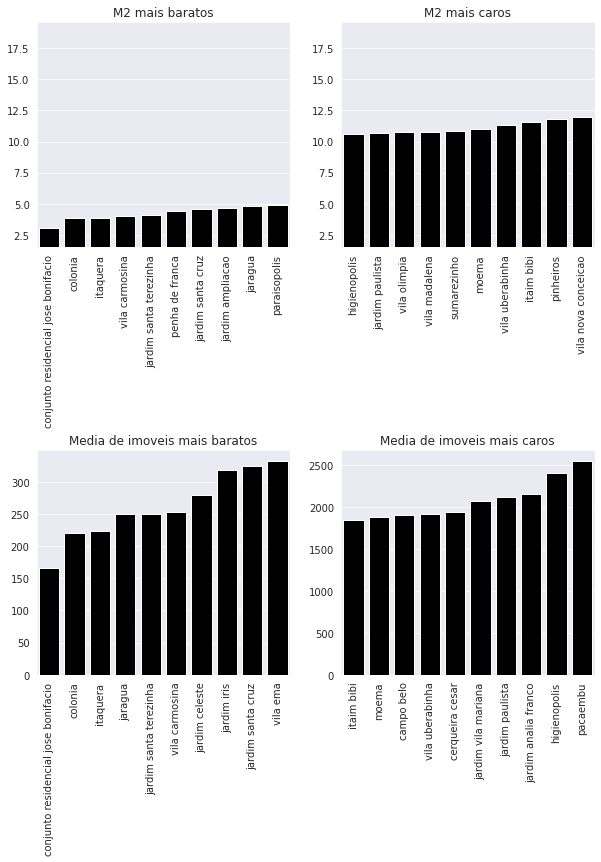

In [9]:
def ranking_10_mais_menos(df, coluna):
    # Agrupa o df por media, e retorna 10+ e 10- por coluna
    bairros_medias = df.groupby('bairros').mean()
    bairros_medias.reset_index(drop = False,
                               inplace = True)
    bairros_medias.sort_values(coluna,
                               inplace = True)
    
    top_min_10 = bairros_medias.head(10)
    top_max_10 = bairros_medias.tail(10)

    return top_min_10, top_max_10

def plot_bar_comp(df, col_x, col_y, titulo):
    # Plot de grafico barras com eixo_x 90 graus
    sns.barplot(col_x,
                col_y,
                data = df,
                color = cor)
    
    plt.title(titulo)
    
    #Eixo x
    plt.xlabel('')
    plt.xticks(rotation = 90)
    
    # Eixo y
    plt.ylabel('')

# Criando os dados com a funcao ranking_10_mais_menos
m2_min, m2_max = ranking_10_mais_menos(data,
                                       'preco_m2_milhares')

preco_min, preco_max = ranking_10_mais_menos(data,
                                             'PRECO_MILHARES')


# Criando a figura e plotango graficos
fig, ax = plt.subplots(figsize = (10, 12))

plt.subplot(2, 2, 1)
plt.ylim(data['preco_m2_milhares'].min(),
         data['preco_m2_milhares'].max())
plot_bar_comp(m2_min,
              'bairros',
              'preco_m2_milhares',
              'M2 mais baratos')

plt.subplot(2, 2, 2)
plt.ylim(data['preco_m2_milhares'].min(),
         data['preco_m2_milhares'].max())
plot_bar_comp(m2_max,
              'bairros',
              'preco_m2_milhares',
              'M2 mais caros')

plt.subplot(2, 2, 3)
plot_bar_comp(preco_min,
              'bairros',
              'PRECO_MILHARES',
              'Media de imoveis mais baratos')

plt.subplot(2, 2, 4)
plot_bar_comp(preco_max,
              'bairros',
              'PRECO_MILHARES',
              'Media de imoveis mais caros')

plt.subplots_adjust(hspace= 0.9)
plt.show()

## 3.3 - Features vs Preco de venda

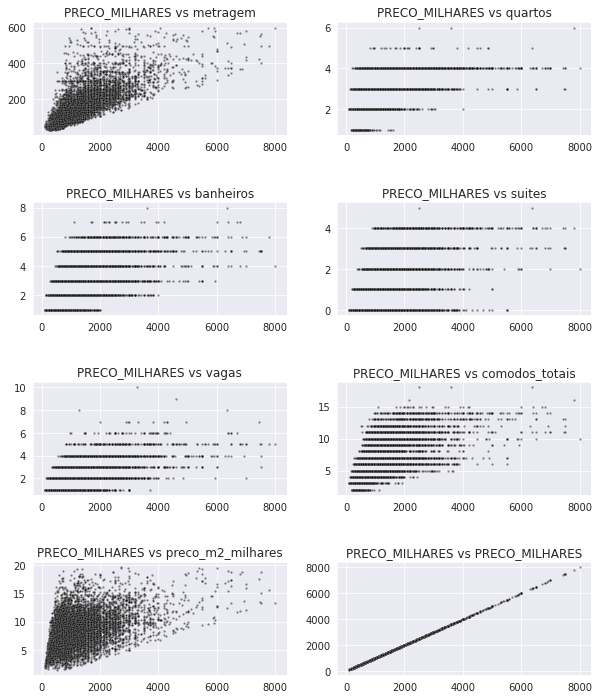

In [10]:
def plot_scatter(df, col_x, col_y):
    # Plot de grafico scatter simples
    sns.scatterplot(col_x,
                    col_y,
                    data = df,
                    alpha = 0.5,
                    s = 5,
                    color = cor)
    
    plt.title('{} vs {}'.format(col_x, col_y))
    
    # Eixo x
    plt.xlabel('')

    #Eixo y
    plt.ylabel('')

# Criando a figura e plotango graficos
fig, ax = plt.subplots(figsize = (10, 12))

plt.subplot(4, 2, 1)
plot_scatter(data, 'PRECO_MILHARES', 'metragem')

plt.subplot(4, 2, 2)
plot_scatter(data, 'PRECO_MILHARES', 'quartos')

plt.subplot(4, 2, 3)
plot_scatter(data, 'PRECO_MILHARES', 'banheiros')

plt.subplot(4, 2, 4)
plot_scatter(data, 'PRECO_MILHARES', 'suites')

plt.subplot(4, 2, 5)
plot_scatter(data, 'PRECO_MILHARES', 'vagas')

plt.subplot(4, 2, 6)
plot_scatter(data, 'PRECO_MILHARES', 'comodos_totais')

plt.subplot(4, 2, 7)
plot_scatter(data, 'PRECO_MILHARES', 'preco_m2_milhares')

plt.subplot(4, 2, 8)
plot_scatter(data, 'PRECO_MILHARES', 'PRECO_MILHARES')

plt.subplots_adjust(hspace= 0.6)
plt.show()

## 3.4 - Feature importance com RFR

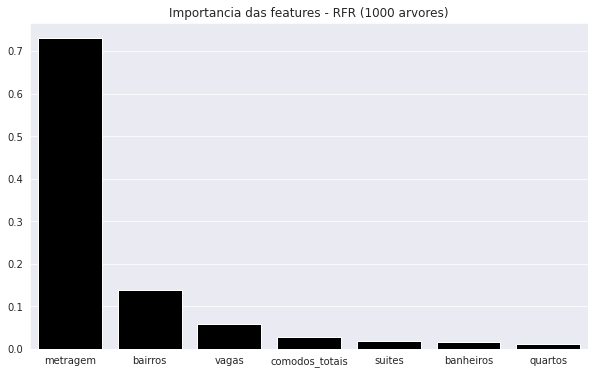

In [11]:
# Obs.: Para preservar o original agora, criei um novo df
# Obs.: Sem o PRECO_MILHARES na previsao, tirei o preco_m2_milhares

# Criando um datarframe novo igual ao principal
data_feat = data.copy().drop('preco_m2_milhares',
                             axis = 1)

# Preparando a coluna bairros (str) para receber ML
le = preprocessing.LabelEncoder()
data_feat['bairros'] = le.fit_transform(data_feat['bairros'])

# Treinando nosso algoritmo RFR com o data_feat e 1000 arvores 
rfr = RandomForestRegressor(n_estimators = 1000)
rfr.fit(data_feat.drop(['PRECO_MILHARES'], axis= 1),
        data_feat['PRECO_MILHARES'])

# Solicitando a importancia de cada feature e montando um df
imp_feat = pd.DataFrame({'colunas':
                         data_feat.drop(['PRECO_MILHARES'],
                                              axis= 1).columns,
                         'importancia':
                         rfr.feature_importances_})

# Ordenando o df baseado na importancia (feature_importances_)
imp_feat = imp_feat.sort_values(by = 'importancia',
                                ascending = False)

def plot_bar(df, col_x, col_y, titulo):
    # Plot de grafico barras simples
    sns.barplot(col_x,
                col_y,
                data = df,
                color = cor)
    
    plt.title(titulo)
    
    #Eixo x
    plt.xlabel('')
    
    # Eixo y
    plt.ylabel('')

# Criando a figura e plotango graficos
fig, ax = plt.subplots(figsize = (10, 6))

plot_bar(imp_feat, 'colunas', 'importancia',
         'Importancia das features - RFR (1000 arvores)')

plt.show()

## 3.5 - Correlacao das colunas

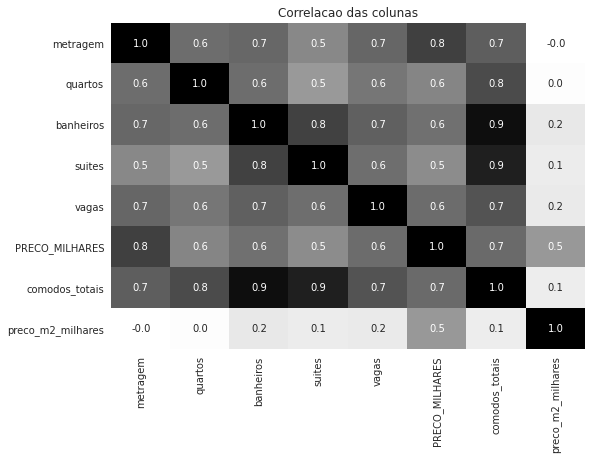

In [12]:
def plot_corr(df, titulo):
    # Plot de grafico correlacao simples
    sns.heatmap(df.corr(), 
                annot= True,
                cmap = 'Greys',
                cbar = False,
                fmt = '.1f')
    
    plt.title(titulo)
    
    #Eixo x
    plt.xlabel('')
    
    # Eixo y
    plt.ylabel('')

# Criando a figura e plotango graficos
fig, ax = plt.subplots(figsize = (8.5, 6))

plot_corr(data, 'Correlacao das colunas')

plt.show()

# **4.0 - Modelo ML e deploy**

1.   Nao deletei colunas, ja que isso se deu melhor nos testes
2.   Apliquei o label encoder do Skelearn na coluna bairros
3.   Nao escalei nenhuma coluna, pois assim performou melhor
4.   Escolhi avaliar pelo MAE e o MSAE, explicacao a seguir
5.   Rodei algoritmos variados, escolhi o de melhor desempenho
6.   Fiz a sintonia fina do melhor algoritmo usando grid cv
7.   Baixei os arquivos necesarios para colocar em producao

## 4.1 - Preparando o dataframe

In [13]:
# Ordenei varias vezes o df, vou embaralha-lo por garantia
data = data.sample(frac = 1).reset_index(drop = True)

# Aplicar o label encoder novamente, copiei de cima
le = preprocessing.LabelEncoder()
data['bairros'] = le.fit_transform(data['bairros'])

# Separando o ds entre features e target
x = data.drop(['preco_m2_milhares', 'PRECO_MILHARES'],
              axis = 1)
y = data['PRECO_MILHARES']

# Obs.: Usarei cross validation, nao tenho treino/teste

## 4.2 - Avaliando alguns modelos

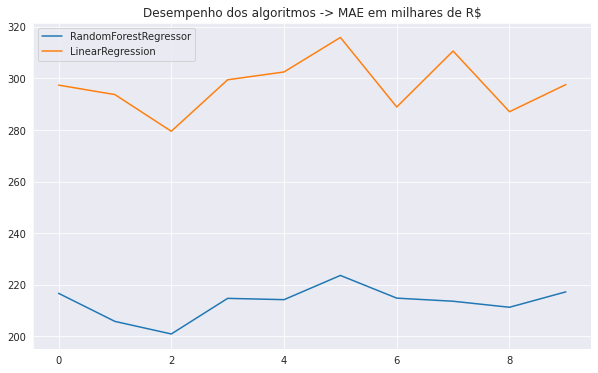

In [14]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression

def plot_avalia_algortimo(features, target, alg_s):
    # Avalia varios algoritmos e traz o plot do resultado
    # Definindo o avaliador oficial
    avaliador = 'neg_mean_absolute_error'
    
    # Criando uma variavel para receber os resultados
    resultados = []

    # Para cadaa algorimto > avaliar e plotar
    for alg in alg_s:
        alg_nome = str(alg).split("(")[0]

        # Avaliando modelo com 10 folds
        scores = cross_val_score(alg,
                                features,
                                target,
                                cv = 10,
                                scoring = avaliador)
        
        # Montando um df com os resultados ()
        scores = pd.DataFrame(scores * (-1),
                              columns = [alg_nome])
        
        # Colocando os resultados na variavel resultados
        resultados.append(scores)
        
    # Juntando os dataframes
    resultados = pd.concat(resultados,
                           axis = 1)
    
    for col in resultados:
        # Retornando um grafico com os resultados
        sns.lineplot(resultados.index,
                     resultados[col],
                     label = col)
        
        # Legenda dos nomes
        plt.legend()

        # Eixo x
        plt.xlabel('')
        
        #Eixo y
        plt.ylabel('')

# Escolhendo os algoritmos que vao ser testados
alg_testes = [RandomForestRegressor(),
              LinearRegression()]

# Criando a figura e plotando os graficos
fig, ax = plt.subplots(figsize = (10, 6))

plot_avalia_algortimo(x, y, alg_testes)

plt.title('Desempenho dos algoritmos -> MAE em milhares de R$')
plt.show()

## 4.3 - Tuning do modelo final

In [15]:
# Com base na secao 5.2 escolhi o XXXXXXXXX

# Usando GridCV vou testar varior parametros

## 4.4 - Preparacao para producao

In [16]:
# Baixar o modelo final e o label encoder